In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams.update({'font.size': 11})

In [3]:
path = '../data/data.csv'
df = pd.read_csv(path)

In [4]:
numeric_columns = df.select_dtypes(include=['number'])
numeric_columns.columns

Index(['Наименование расщелины', 'Количество труб',
       'Количество дополнительных отвилков', 'Количество пилотных отвилков',
       'Глубина по отвилку', 'Глубина первого отвилка',
       'Путь поиска в первом отвилке', 'Общее время поиска',
       'Общее время активного поиска', 'Общее время простоев',
       'Количество аварий', 'Количество брака',
       'Количество геологических осложнений', 'Количество осложнений',
       'Количество простоев по метеоусловиям', 'Количество простоев',
       'Количество ремонтов', 'Количество простоев без виновника',
       'Количество простоев по вине королевства',
       'Количество простоев в поиске',
       'Количество простоев в наклонном поиске',
       'Количество простоев по зельям',
       'Количество простоев в контроле поиска',
       'Количество простоев в конце расщелины',
       'Количество простоев по долбилам',
       'Количество простоев по вине исследователей',
       'Количество простоев по креплениям', 'Количество простоев (

In [5]:
categor_columns = df.select_dtypes(include=['object'])
categor_columns.columns

Index(['Наименование королевства', 'Наименование земли', 'Наименование хребта',
       'Цель', 'Тип расщелины', 'Категория расщелины', 'Назначение расщелины',
       'Участки', 'Тип отвилка', 'Технологическая особенность',
       'Статус поиска', 'Помощник по контролю поиска', 'Помощник по поиску',
       'Помощник по наклонным расщелинам', 'Помощник по зельям',
       'Помощник по долбилам', 'Помощник по исследованиям',
       'Помощник по укреплению', 'Помощник по огненным заклятиям',
       'Помощник по подвескам', 'Помощник по вырезке окна', 'Тип инструмента',
       'Дата начала поиска', 'Дата окончания поиска'],
      dtype='object')

In [ ]:
# print(df.info())

### Обработка пропусков 

Если признак имеет более чем 50% пропущенных значений, то его можно удалить, так как информация в нем минимальна.
Остальные числовые признаки заполняются медианой, а категориальные – наиболее частыми значениями (модой).

In [6]:
# Удаление признаков с более чем 50% пропущенных значений
threshold = 0.5
df = df.loc[:, df.isnull().mean() < threshold]

In [7]:
# Заполнение пропусков
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

In [8]:
# Проверка, что все пропуски обработаны
df.isnull().sum().sum()

0

In [9]:
# Функция для расчета Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))    
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [10]:
# Применим Cramer's V для категориальных признаков
categorical_features = [
    'Наименование королевства', 'Наименование земли', 'Наименование хребта',
    'Цель', 'Тип расщелины', 'Категория расщелины', 'Назначение расщелины',
    'Участки', 'Тип отвилка', 'Технологическая особенность',
    'Статус поиска', 'Помощник по контролю поиска', 'Помощник по поиску',
    'Помощник по наклонным расщелинам', 'Помощник по зельям',
    'Помощник по долбилам', 'Помощник по исследованиям',
    'Помощник по укреплению', 'Помощник по огненным заклятиям',
    'Помощник по подвескам', 'Помощник по вырезке окна', 'Тип инструмента',
]


In [13]:
from scipy.stats import chi2_contingency

In [14]:
# Расчет матрицы корреляций Cramer's V для категориальных признаков
cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_features), len(categorical_features))), 
                                index=categorical_features, columns=categorical_features)

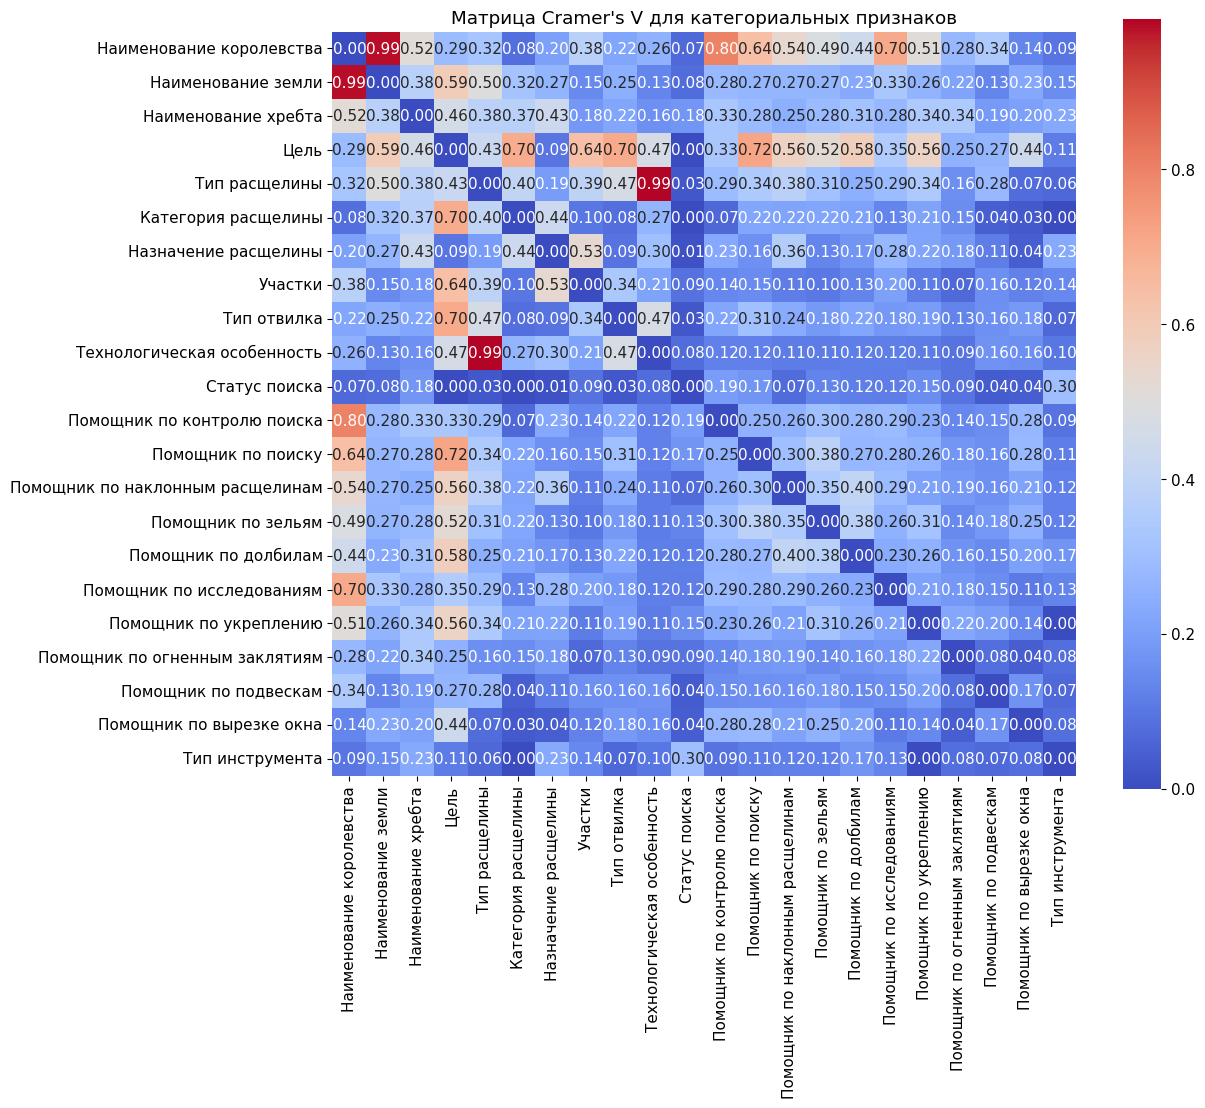

In [15]:
for i in range(len(categorical_features)):
    for j in range(i+1, len(categorical_features)):
        cramers_v_matrix.iloc[i, j] = cramers_v(df[categorical_features[i]], df[categorical_features[j]])
        cramers_v_matrix.iloc[j, i] = cramers_v_matrix.iloc[i, j]

# Визуализируем матрицу Cramer's V
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f')
plt.title("Матрица Cramer's V для категориальных признаков")
plt.show()

In [18]:
# Выбор порога корреляции
threshold = 0.6
correlated_features = set()

In [19]:
# Проход по матрице корреляции
for i in range(len(cramers_v_matrix.columns)):
    for j in range(i):
        corr_value = cramers_v_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            colname1 =cramers_v_matrix.columns[i]
            colname2 = cramers_v_matrix.columns[j]
            correlated_features.add((colname1, colname2, corr_value))

# Вывод коррелирующих признаков
for feature1, feature2, corr_value in correlated_features:
     print(f"Коррелирующие признаки: {feature1} и {feature2}, значение корреляции: {corr_value:.2f}")

Коррелирующие признаки: Помощник по поиску и Цель, значение корреляции: 0.72
Коррелирующие признаки: Участки и Цель, значение корреляции: 0.64
Коррелирующие признаки: Помощник по исследованиям и Наименование королевства, значение корреляции: 0.70
Коррелирующие признаки: Помощник по контролю поиска и Наименование королевства, значение корреляции: 0.80
Коррелирующие признаки: Категория расщелины и Цель, значение корреляции: 0.70
Коррелирующие признаки: Наименование земли и Наименование королевства, значение корреляции: 0.99
Коррелирующие признаки: Технологическая особенность и Тип расщелины, значение корреляции: 0.99
Коррелирующие признаки: Тип отвилка и Цель, значение корреляции: 0.70
Коррелирующие признаки: Помощник по поиску и Наименование королевства, значение корреляции: 0.64


### Обработка выбросов

Так как выбросы могут сильно повлиять на результаты моделей, то для их для обнаружения в целевой переменной и других количественных признаках использую Boxplot.

In [ ]:
# Выявление выбросов в целевой переменной
sns.boxplot(df['Общее время поиска'], color='lightblue')
plt.title('Выбросы в целевой переменной')
plt.xlabel('Общее время поиска')
plt.grid()
plt.show()

По графику видны выбросы, для более точно определения выбросов использую метод IQR. Значения, выходящие за пределы диапазона , будут считаться выбросами.

In [ ]:
# for column in df.select_dtypes(include=['float64', 'int64']).columns:
#     df[column] = np.log1p(df[column])  # Логарифм от (x+1), чтобы избежать логарифма от нуля

In [ ]:
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

In [ ]:
# # Вычисление IQR для целевой переменной
# Q1 = df['Общее время поиска'].quantile(0.25)
# Q3 = df['Общее время поиска'].quantile(0.75)
# IQR = Q3 - Q1

In [ ]:
# # Границы для обнаружения выбросов
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

In [ ]:
# # Фильтрация данных на основе границ
# outliers = df[(df['Общее время поиска'] < lower_bound) | (df['Общее время поиска'] > upper_bound)]
# print(f"Количество выбросов в целевой переменной: {len(outliers)}")

In [ ]:
# # Проверка, сколько данных теряется, если удалить выбросы
# print(f"Процент данных, приходящихся на выбросы: {len(outliers) / len(df) * 100:.2f}%")

Для избежания потери данных, сглажу выбросы, вместо удаления.

In [ ]:
# # Обрезка выбросов до границ
# df['Общее время поиска'] = df['Общее время поиска'].apply(lambda x: lower_bound if x < lower_bound 
#                                                           else upper_bound if x > upper_bound else x)

In [ ]:
# Гистограмма и график плотности для целевой переменной
sns.histplot(df['Общее время поиска'], kde=True, color='teal')
plt.title('Распределение целевой переменной: Общее время поиска')
plt.xlabel('Общее время поиска')
plt.ylabel('Частота')
plt.show()

После обрезки выбросов построю Boxplot еще раз, чтобы убедиться в эффективности обработки.

In [ ]:
# Повторное построение Boxplot после обработки выбросов
sns.boxplot(df['Общее время поиска'], color='lightblue')
plt.title('Целевая переменная после обработки выбросов')
plt.xlabel('Общее время поиска')
plt.show()

После обрезки, можно заметить, что выбросов не осталось, что свидетельсвет об эффеткивности проведенной обрезки выбросов.

### EDA

In [ ]:
numeric_features = ['Наименование расщелины', 'Количество труб',
       'Количество дополнительных отвилков', 'Количество пилотных отвилков',
       'Глубина по отвилку', 'Общее время поиска',
       'Общее время активного поиска', 'Общее время простоев',
       'Количество аварий', 'Количество брака',
       'Количество геологических осложнений', 'Количество осложнений',
       'Количество простоев по метеоусловиям', 'Количество простоев',
       'Количество ремонтов', 'Количество простоев без виновника',
       'Количество простоев по вине королевства',
       'Количество простоев в поиске',
       'Количество простоев в наклонном поиске',
       'Количество простоев по зельям',
       'Количество простоев в контроле поиска',
       'Количество простоев в конце расщелины',
       'Количество простоев по долбилам',
       'Количество простоев по вине исследователей',
       'Количество простоев по креплениям', 'Количество простоев (прочие)',
       'Общий путь поиска']
for feature in numeric_features:
    sns.histplot(df[feature], kde=True)
    plt.title(f'Распределение {feature}')
    plt.show()

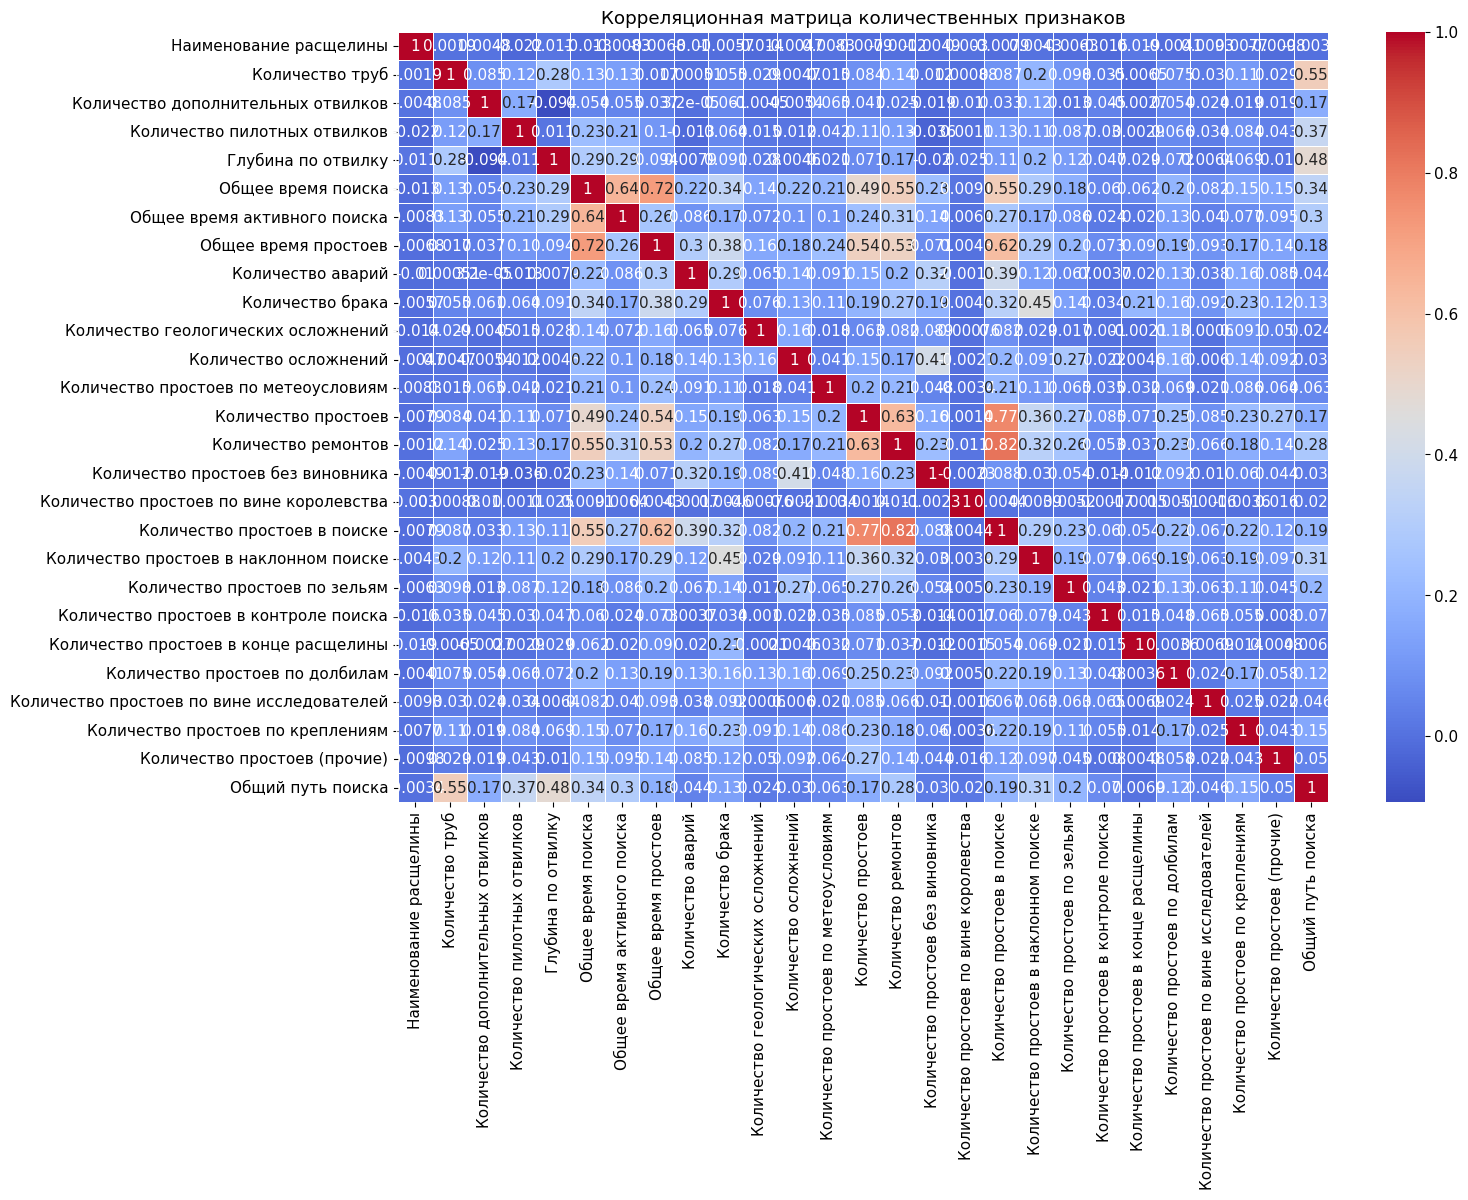

In [8]:
# plt.figure(figsize=(15, 10))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица количественных признаков')
plt.show()

In [22]:
# Выбор порога корреляции
threshold = 0.5
correlated_features = set()

In [23]:
# Проход по матрице корреляции
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            colname1 = corr_matrix.columns[i]
            colname2 = corr_matrix.columns[j]
            correlated_features.add((colname1, colname2, corr_value))

# Вывод коррелирующих признаков
for feature1, feature2, corr_value in correlated_features:
     print(f"Коррелирующие признаки: {feature1} и {feature2}, значение корреляции: {corr_value:.2f}")

Коррелирующие признаки: Количество простоев в поиске и Общее время поиска, значение корреляции: 0.55
Коррелирующие признаки: Общее время простоев и Общее время поиска, значение корреляции: 0.72
Коррелирующие признаки: Общее время активного поиска и Общее время поиска, значение корреляции: 0.64
Коррелирующие признаки: Количество простоев в поиске и Количество ремонтов, значение корреляции: 0.82
Коррелирующие признаки: Количество ремонтов и Общее время простоев, значение корреляции: 0.53
Коррелирующие признаки: Количество простоев и Общее время простоев, значение корреляции: 0.54
Коррелирующие признаки: Общий путь поиска и Количество труб, значение корреляции: 0.55
Коррелирующие признаки: Количество простоев в поиске и Общее время простоев, значение корреляции: 0.62
Коррелирующие признаки: Количество ремонтов и Количество простоев, значение корреляции: 0.63
Коррелирующие признаки: Количество ремонтов и Общее время поиска, значение корреляции: 0.55
Коррелирующие признаки: Количество прост

In [ ]:
categorical_features = ['Наименование королевства', 'Тип расщелины', 'Статус поиска']

In [ ]:
for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=feature, palette='viridis')
    plt.title(f'Распределение признака: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Влияние Наименование королевства на Общее время поиска
sns.boxplot(data=df, x='Наименование королевства', y='Общее время поиска', palette='Set3')
plt.title('Влияние Наименование королевства на Общее время поиска')
plt.xlabel('Наименование королевства')
plt.ylabel('Общее время поиска')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# b) Влияние Тип расщелины на Общее время поиска

sns.boxplot(data=df, x='Тип расщелины', y='Общее время поиска', palette='Set2')
plt.title('Влияние Тип расщелины на Общее время поиска')
plt.xlabel('Тип расщелины')
plt.ylabel('Общее время поиска')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Создаем новый признак - длительность поиска
df['Длительность поиска'] = (pd.to_datetime(df['Дата окончания поиска']) - pd.to_datetime(df['Дата начала поиска'])).dt.days

In [ ]:
# Гистограмма для нового признака
sns.histplot(df['Длительность поиска'], kde=True, color='purple')
plt.title('Распределение длительности поиска')
plt.xlabel('Длительность поиска (дни)')
plt.ylabel('Частота')
plt.show()

In [ ]:
quantitative_features = ['Количество труб', 'Количество аварий', 'Количество простоев']

In [ ]:
for feature in quantitative_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True, color='skyblue')
    plt.title(f'Распределение признака: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()


### Построение модели

В качестве первой модели был выбран случайный лес. Перед разделением данных на тестовую и обучающую выборки, категориальные признаки были закодированы, а количественные признаки масштабированы.

In [ ]:
# Кодирование категориальных признаков
data = pd.get_dummies(df, columns=df.select_dtypes(include=['object']).columns, drop_first=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Масштабирование количественных признаков
scaler = StandardScaler()
data[data.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(data.select_dtypes(include=['float64', 'int64']))

In [ ]:
from sklearn.model_selection import train_test_split

# Разделение данных
X = data.drop(columns=['Общее время поиска'])  # Целевая переменная
y = data['Общее время поиска']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Обучение модели
rf_model  = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Предсказания
y_pred = rf_model.predict(X_test)

# Оценка метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

* Оптимизация гиперпараметров: Используйте GridSearchCV или RandomizedSearchCV для подбора гиперпараметров, чтобы улучшить качество модели.
* Поделить на тестовую и обущаующу не рандомно, а посомтреть по датам 
* Сравнение моделей: Попробуйте другие модели (например, градиентный бустинг, линейную регрессию, XGBoost), чтобы найти ту, которая даст наилучшие результаты.
* Кросс-валидация: Используйте кросс-валидацию для оценки модели, чтобы убедиться, что результаты стабильны и модель не переобучилась на тренировочные данные.
* Важность признаков: Оцените важность признаков (например, через feature_importances_ в случайном лесе), чтобы понять, какие признаки наиболее влияют на предсказания.

Для улучшения качесьва модели, проводится подбор гипер параметров с помощью Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Сетка гиперпараметров для подбора
param_grid = {
    'n_estimators': [100, 200, 300],           # Количество деревьев
    'max_depth': [None, 10, 20, 30],           # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10],           # Минимальное количество образцов для разбиения узла
    'min_samples_leaf': [1, 2, 4],             # Минимальное количество образцов в листе
    'max_features': ['auto', 'sqrt']           # Количество признаков для выбора в каждом узле
}

In [ ]:
# Настройка Grid Search с использованием кросс-валидации на 5 фолдов
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, 
                           n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

In [ ]:
# Подгонка модели на тренировочных данных
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры: ", grid_search.best_params_)

In [ ]:
# Обучение модели с лучшими параметрами
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

In [ ]:
# Оценка модели на тестовых данных
y_pred = best_rf_model.predict(X_test)

In [ ]:
mae_best = mean_absolute_error(y_test, y_pred)
mse_best = mean_squared_error(y_test, y_pred)
rmse_best = mean_squared_error(y_test, y_pred, squared=False)

print(f"MAE: {mae_best}")
print(f"MSE: {mse_best}")
print(f"RMSE: {rmse_best}")